<h1 style="text-align: center;"> EE6380 - DEEP LEARNING - ASSIGNMENT 5</h1>
<h2 style="text-align: right;">  ATHARV RAMESH NAIR <br>EE20BTECH11006</h2>

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset
from sklearn.manifold import TSNE

## BASIC CNN MODEL

In [136]:
class CNN_model(nn.Module):

    def __init__(self,image_size =28, mlp_hidden_layer = 49,num_classes=10):

        super(CNN_model, self).__init__()
        self.conv_layer1 = nn.Sequential(nn.Conv2d(in_channels =1, out_channels = 4,kernel_size = 5,stride =1 , padding = 2),
                                    nn.ReLU(),
                                    )   
        
        self.pooling1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer2 = nn.Sequential(nn.Conv2d(in_channels =4, out_channels = 4, kernel_size = 5, stride=1, padding = 2),
                                    nn.ReLU(),
                                    )
        
        self.pooling2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.mlp = nn.Sequential(nn.Linear(4*(image_size//4)*(image_size//4), mlp_hidden_layer),
                            nn.ReLU(),
                            nn.Linear(mlp_hidden_layer, num_classes),
                            #nn.Softmax()
                            )
        
    def forward(self, x):

        ## Input is (batch_size, 1, 28, 28)
        x = self.conv_layer1(x)
        activation1 = x
        ## Output is (batch_size, 4, 28, 28)
        x = self.pooling1(x)
        ## Output is (batch_size, 4, 14, 14)
        x = self.conv_layer2(x)
        activation2 = x
        ## Output is (batch_size, 4, 14, 14)
        x = self.pooling2(x)
        ## Output is (batch_size, 4, 7, 7)
        x = x.view(x.size(0), -1)
        flat = x
        ## Output is (batch_size, 4*7*7)
        x = self.mlp(x)
        ## Output is (batch_size, 10)
        return x,activation1,activation2,flat



In [292]:
random_seed = 1
torch.manual_seed(random_seed)

In [143]:
## Training

def train(model, train_loader, test_loader,optimizer, criterion,epoch):

    training_loss = []
    training_accuracy = []

    testing_loss = []
    testing_accuracy = []

    activations = []
    
    for epoch in range(epoch):
        model.train()
        train_correct = 0 
        epoch_loss = 0
        for idx,(img,label) in enumerate(train_loader):

            optimizer.zero_grad()

            output,a1,a2,_ = model(img)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            #print(output)
            prediction = output.argmax(dim=1, keepdim=True)
            #print(prediction)
            #print(train_correct)
            train_correct += torch.sum(prediction == label.reshape(prediction.shape)).item()
            # train_correct += prediction.eq(label.view_as(prediction)).sum().item()
        training_loss.append(epoch_loss/len(train_loader))
        # p#rint(train_correct)
        training_accuracy.append(train_correct/len(train_loader.dataset))
        activations.append([a1,a2])
       

            ## Testing
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for idx,(img,label) in enumerate(test_loader):
                output,_,_,_ = model(img)
                test_loss += criterion(output,label).item()
                prediction = output.argmax(dim=1, keepdim=True)
                correct += prediction.eq(label.view_as(prediction)).sum().item()

        test_loss /= len(test_loader)
        testing_loss.append(test_loss)
        testing_accuracy.append(correct/len(test_loader.dataset))

    print('Training Loss: {:.6f} \tTraining Accuracy: {:.6f} \tTesting Loss: {:.6f} \tTesting Accuracy: {:.6f}'.format(
       (training_loss[-1]), (training_accuracy[-1]), testing_loss[-1], testing_accuracy[-1]))
        
    
    ## Plotting the training loss and testing loss vs epochs
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 1, 1)
    plt.grid(True)
    plt.plot(training_loss,label = 'Training Loss')
    plt.plot(testing_loss,label = 'Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(training_accuracy,label = 'Training Accuracy')
    plt.plot(testing_accuracy,label = 'Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return training_loss,training_accuracy,testing_loss,testing_accuracy,activations

    # return
    

In [59]:
batch_size_train = 64
batch_size_test = 64

### DOWNLOADING DATASET AND SAMPLING 1000 (100 PER CLASS) IMAGES FROM TRAINING SET AND 100 (10 PER EACH CLASS)IMAGES FROM TEST SET

In [22]:
train_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(
                   (0.1307,), (0.3081,))
                             ])
test_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(
                   (0.1307,), (0.3081,))
                             ])

train_dataset = datasets.MNIST('data/', train=True, download=True,transform =  train_transforms)
test_dataset = datasets.MNIST('data/', train=False, download=True,transform = test_transforms)
sample_test_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=False)
sample_train_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 1, shuffle= False)

In [133]:
train_subset_indices = []
count = [0]*10
for idx, (img, label) in enumerate(sample_train_loader):
    count[label.item()] += 1
    if count[label.item()] <= 100:
        train_subset_indices.append(idx)

 
    for i in range(10):
        if count[i] >=100:
            flag = True
        else:
            flag = False
            break
    
    if flag:
        break

def get_train_loader(batch_size):
    train_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True,drop_last=False)
    return train_dataloader

train_subset_dataset = Subset(train_dataset, train_subset_indices)
train_dataloader = get_train_loader(batch_size_train)

In [134]:
test_subset_indices= []

count = [0]*10
for idx, (img, label) in enumerate(sample_test_loader):
    count[label.item()] += 1
    if count[label.item()] <= 10:
        test_subset_indices.append(idx)

 
    for i in range(10):
        if count[i] >=10:
            flag = True
        else:
            flag = False
            break
    # print(count)
    if flag:
        break


test_subset_dataset = Subset(test_dataset, test_subset_indices)
test_dataloader = DataLoader(test_subset_dataset, batch_size=10, shuffle=False,drop_last=False)


### Function to set model optimizer and call train function

In [242]:
def set_params_train(model, epoch, lr, optimizer = "SGD",mometum = 0):
    '''
    Set the hyperparameters for the model
    optimizer: "SGD" or "RMSprop"
    '''
    criterion = nn.CrossEntropyLoss()
    if optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mometum)
    elif optimizer == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001,alpha=0.9, eps=1e-08)
    else:
        raise ValueError("Optimizer should be SGD or Adam")
    _,_,_,_,activations = train(model, train_dataloader, test_dataloader,optimizer, criterion,epoch = epoch)

    return activations
    

### Function to get bottleneck features on all the test images

In [222]:
def get_bottleneck(model,test_dataloader):
    
    botleneck = {}
    model.eval()
    for idx,(img,label) in enumerate(test_dataloader):
        _,_,_,flat = model(img)
        for i in range(len(flat)):
            botleneck[flat[i]] = label[i]
    
    botlleneck = sorted(botleneck.items(), key=lambda x: x[1])
    botlleneck = [x[0] for x in botlleneck]
    botlleneck = [x.reshape(1,-1) for x in botlleneck]
    botlleneck = torch.cat(botlleneck)
    return botlleneck

In [227]:
def plot_activations(activations):
    ### Plotting the activations of the first slice of the first convolutional layer for 10 images in the test set for the first 15 epochs
    plt.figure(figsize=(10, 7))
    for i in range(0,15,1):
        plt.subplot(3,5,i+1)
        to_plot = activations[i][0][0][0].detach().numpy()
        plt.imshow(to_plot,cmap='gray')

    plt.show()

### Training BASIC CNN MODEL WHEN BATCH SIZE = 64

<ul>
  <li>For almost all models, 15 epochs have proven to be insufficient for convergence. Some optimization techniques have converged faster. This can be interpreted the Loss vs Epochs Graphs</li>
  <li>I have used learning rates = 0.01 and 0.001 for some of the optimizers. LR = 0.01 converges faster in all cases. Morever, with Vanilla SGD , LR = 0.001 does not converge even after 100 epochs</li>
  <li> Test Accuracy of the classifier has been provided just above the corresponding graphs 
</ul>


### VANILLA SGD WITH LR = 0.001 PERFORMS POORLY

In [138]:
### example test for TSNE and Activation map
test_image = next(iter(test_dataloader))[0][0].unsqueeze(0)

Training Loss: 2.147998 	Training Accuracy: 0.327000 	Testing Loss: 2.154488 	Testing Accuracy: 0.340000


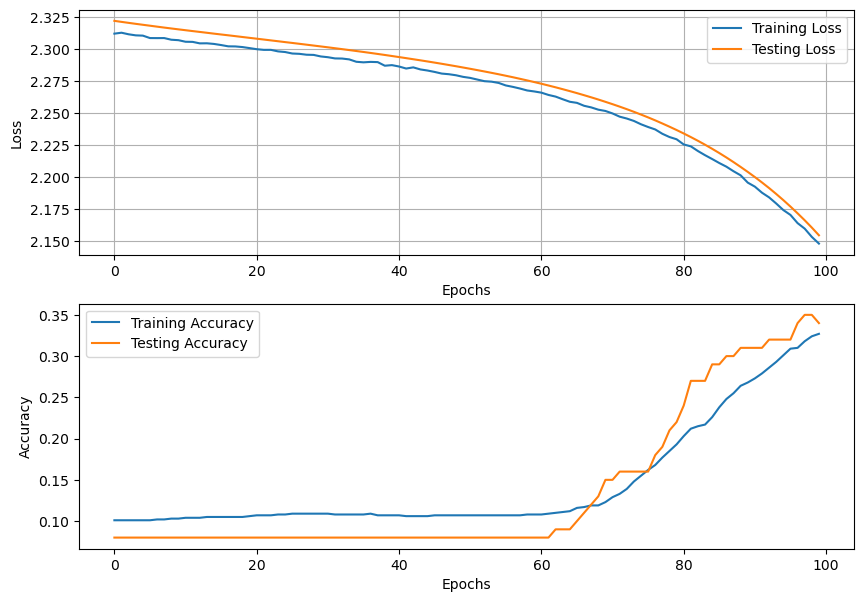

In [146]:
vanilla_model = CNN_model()
activations = set_params_train(vanilla_model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0)

### VANILLA SGD WITH LR = 0.01 PERFORMS MUCH BETTER BUT TAKES 100 EPOCHS TO CONVERGE

Training Loss: 0.080231 	Training Accuracy: 0.979000 	Testing Loss: 0.318745 	Testing Accuracy: 0.890000


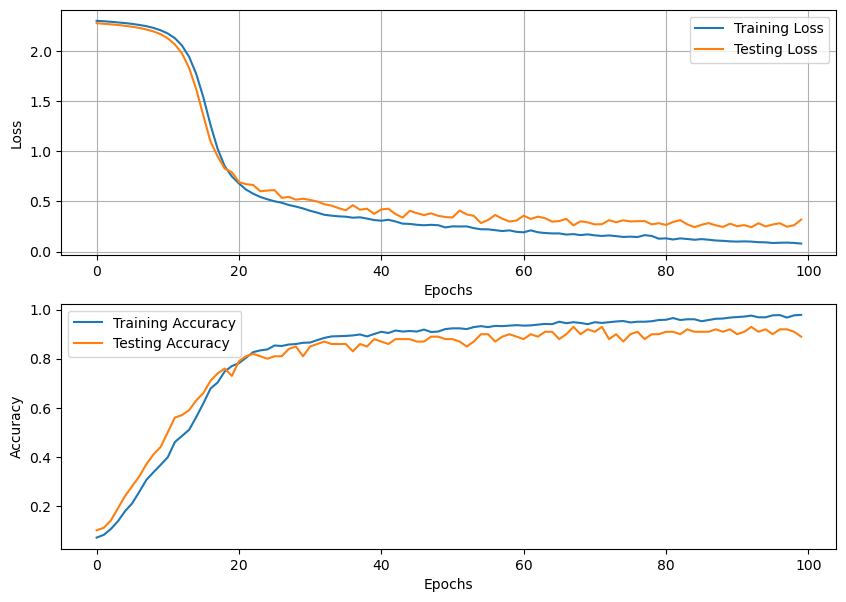

In [243]:
vanilla_model = CNN_model()
flat_vanilla_initial = get_bottleneck(vanilla_model,test_dataloader).detach().numpy()
activations = set_params_train(vanilla_model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)
flat_vanilla_final = get_bottleneck(vanilla_model,test_dataloader).detach().numpy()

##### ACTIVATION MAPS OBTAINED WHILE TRAINING. SINCE DATASET IS SHUFFLED AT EVERY EPOCH, THE ACTIVATION MAPS ARE FOR DIFFERENT INPUTS

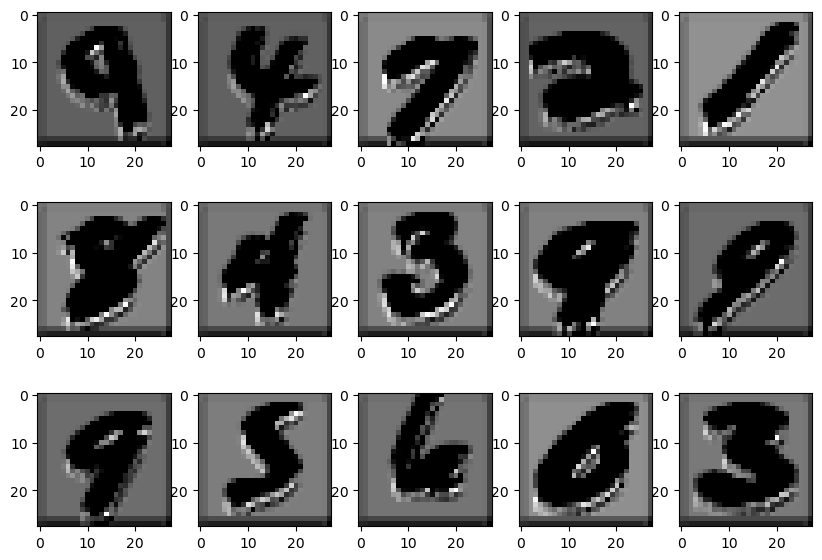

In [244]:
plot_activations(activations)

### SGD WITH MOMENTUM = 0.9 
### FROM THE GRAPH BELOW, WE CAN SEE THAT IT CONVERGES MUCH FASTER THAN VANILLA SGD

#### LR = 0.001

Training Loss: 0.059232 	Training Accuracy: 0.989000 	Testing Loss: 0.247399 	Testing Accuracy: 0.930000


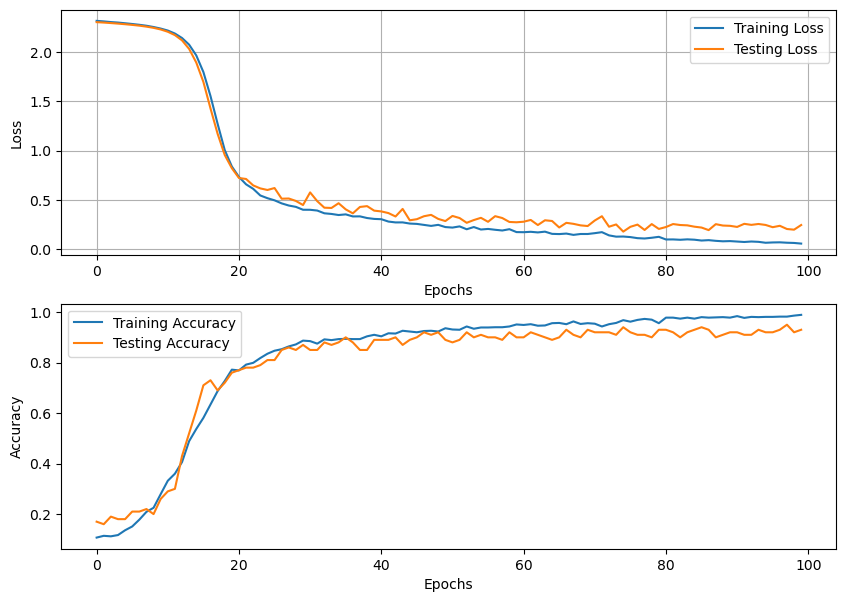

In [245]:
model = CNN_model()
flat_momentum_initial = get_bottleneck(model,test_dataloader).detach().numpy()
activations = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)
flat_momentum_final = get_bottleneck(model,test_dataloader).detach().numpy()

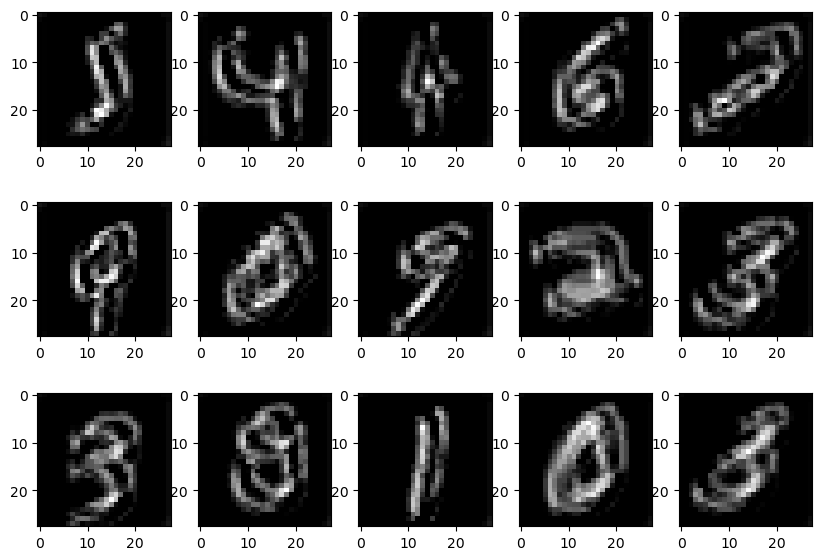

In [246]:
plot_activations(activations)

#### LR = 0.01 (FASTER CONVERGENCE)

Training Loss: 0.001062 	Training Accuracy: 1.000000 	Testing Loss: 0.166680 	Testing Accuracy: 0.960000


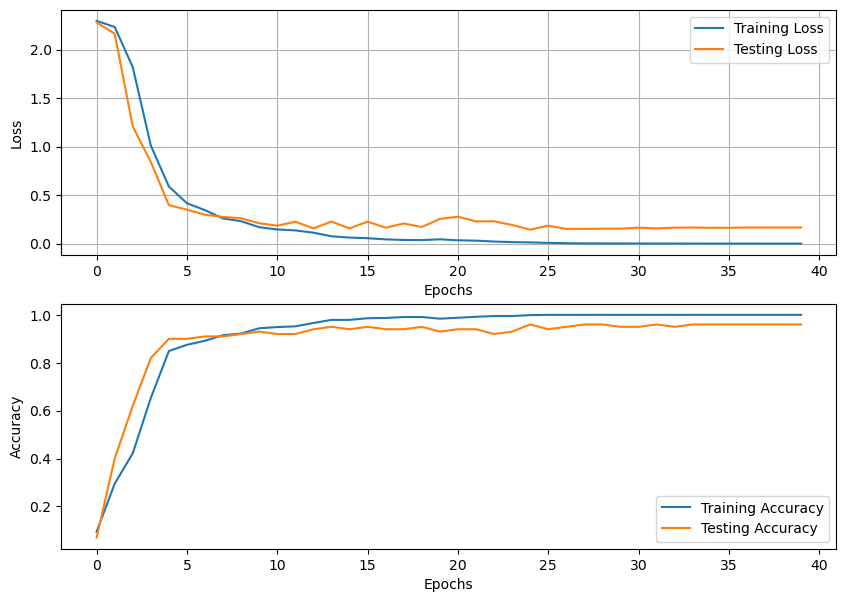

In [247]:
model = CNN_model()
flat_momentum_initial = get_bottleneck(model,test_dataloader).detach().numpy()
activations = set_params_train(model,epoch=40,lr = 0.01,optimizer="SGD",mometum=0.9)
flat_momentum_final = get_bottleneck(model,test_dataloader).detach().numpy()

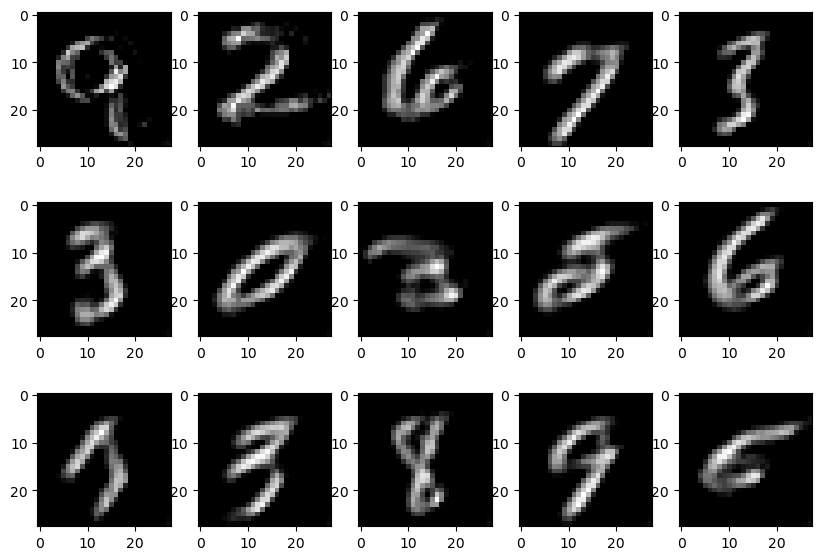

In [248]:
plot_activations(activations)

### We can see than SGD with momentum performs better than Vanilla SGD and also converges faster

### RMSprop

Training Loss: 0.021922 	Training Accuracy: 0.993000 	Testing Loss: 0.173240 	Testing Accuracy: 0.960000


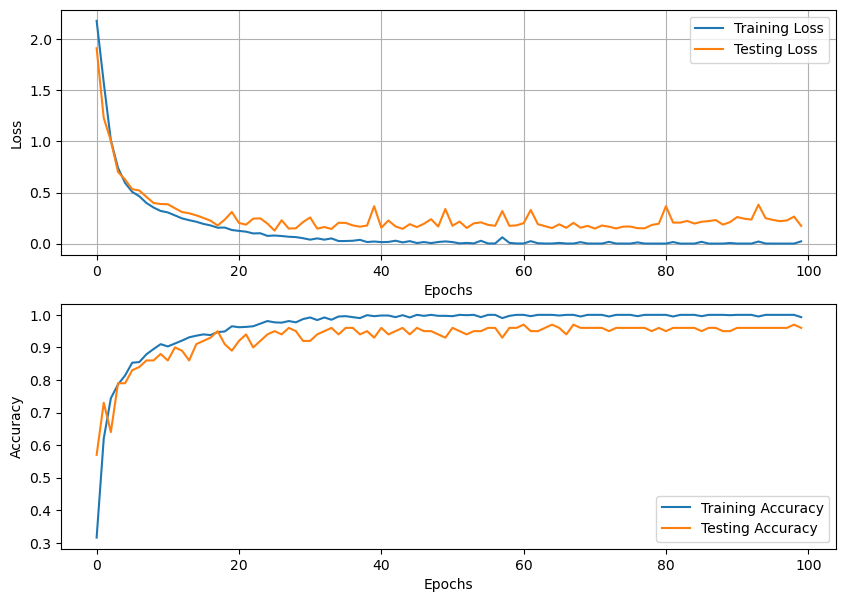

In [257]:
model = CNN_model()
flat_rms_initial = get_bottleneck(model,test_dataloader).detach().numpy()
activations = set_params_train(model,epoch=100,lr = 0.001,optimizer="RMSprop")
flat_rms_final = get_bottleneck(model,test_dataloader).detach().numpy()

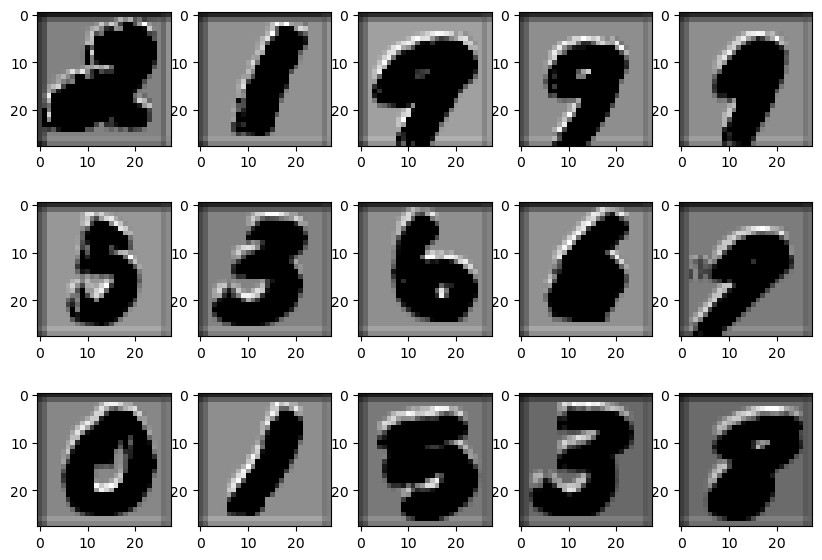

In [250]:
plot_activations(activations)

Training Loss: 0.000075 	Training Accuracy: 1.000000 	Testing Loss: 0.077446 	Testing Accuracy: 0.960000


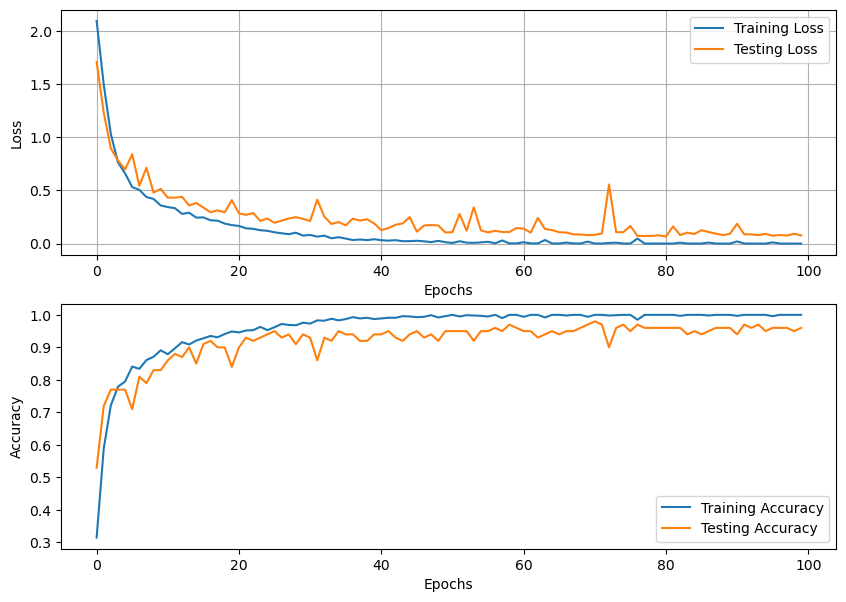

In [258]:
model = CNN_model()
flat_rms_initial = get_bottleneck(model,test_dataloader).detach().numpy()
activations = set_params_train(model,epoch=100,lr = 0.01,optimizer="RMSprop")
flat_rms_final = get_bottleneck(model,test_dataloader).detach().numpy()

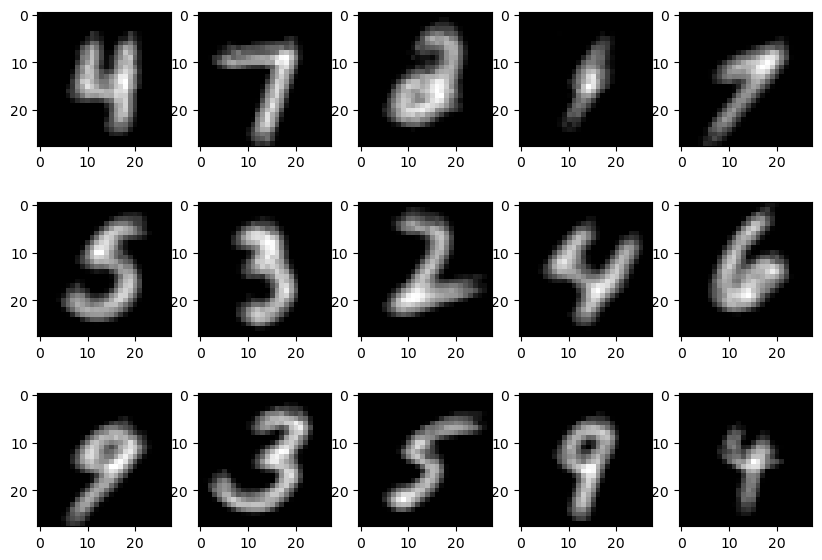

In [259]:
plot_activations(activations)

### Lets take a single test image and plot the activations of all the 4 channel of both the convolutional layers
###  Taking the model trained using RMS_prop

In [260]:
test_image = next(iter(test_dataloader))[0][0].unsqueeze(0)
output,activation1,activation2,_ = model(test_image)

##### First Convolutional Layer

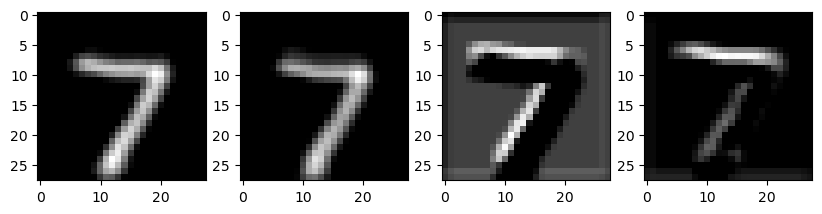

In [261]:
plt.figure(figsize=(10, 7))
for i in range(4):
    plt.subplot(1,4,i+1)
    to_plot = activation1[0][i].detach().numpy()
    plt.imshow(to_plot,cmap='gray')

##### Second Convolutional Layer

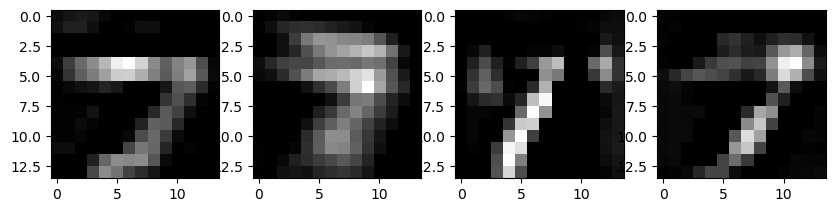

In [262]:
plt.figure(figsize=(10, 7))
for i in range(4):
    plt.subplot(1,4,i+1)
    to_plot = activation2[0][i].detach().numpy()
    plt.imshow(to_plot,cmap='gray')

### WITH BATCH SIZE = 32

Training Loss: 0.005254 	Training Accuracy: 1.000000 	Testing Loss: 0.276476 	Testing Accuracy: 0.940000


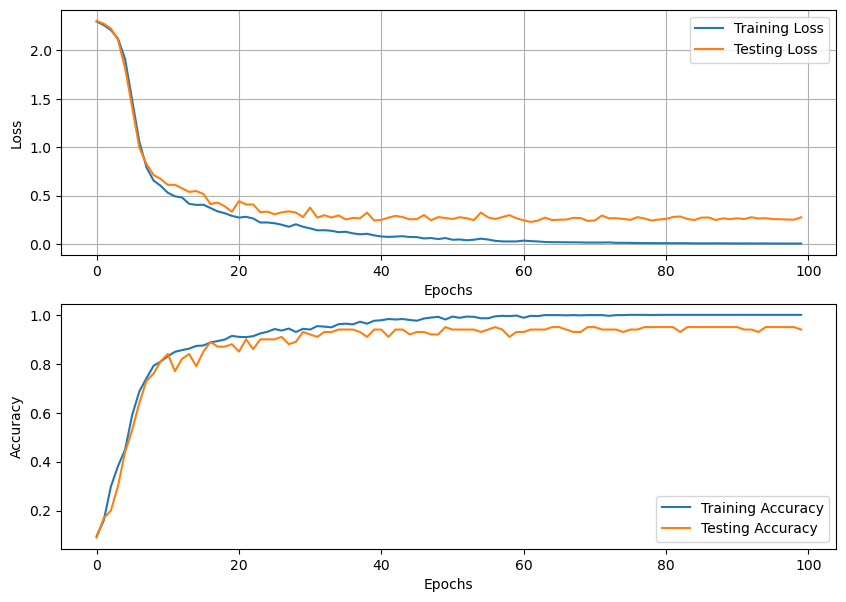

In [291]:
train_dataloader = get_train_loader(32)
model = CNN_model()
activations = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)

### The performance of the model seems to be similar. So we continue with batch size of 64

## TSNE Visualization of BottleNeck Layer (Output of Flattening Function)

In [226]:
def plot_tsne(flat_vanilla_initial, flat_vanilla_final):

    combined = np.concatenate((flat_vanilla_initial, flat_vanilla_final), axis=0)

    labels = np.repeat(np.arange(10), 10)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    transformed_data = tsne.fit_transform(combined)

    transformed_initial = transformed_data[:100, :]
    transformed_final = transformed_data[100:, :]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    for i in range(10):
        plt.scatter(transformed_initial[labels == i, 0], transformed_initial[labels == i, 1], label=f'Class {i}')
    plt.title('t-SNE Visualization - Initial Features')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(10):
        plt.scatter(transformed_final[labels == i, 0], transformed_final[labels == i, 1], label=f'Class {i}')
    plt.title('t-SNE Visualization - Final Features')
    plt.legend()

    plt.show()

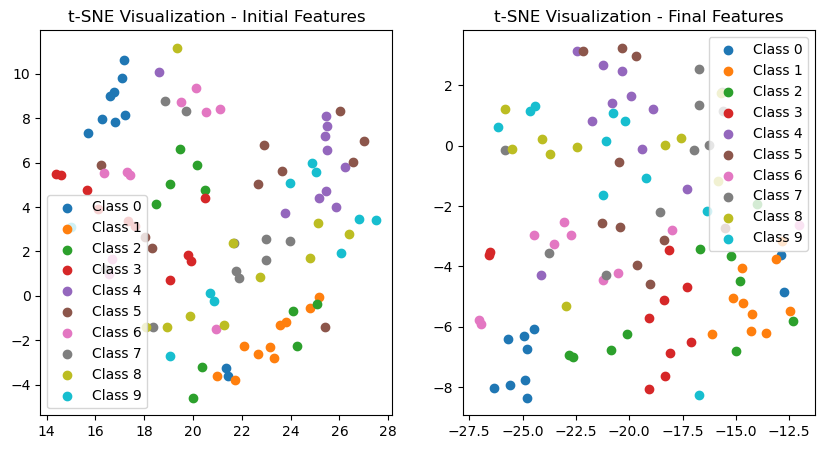

In [255]:
plot_tsne(flat_vanilla_initial, flat_vanilla_final)

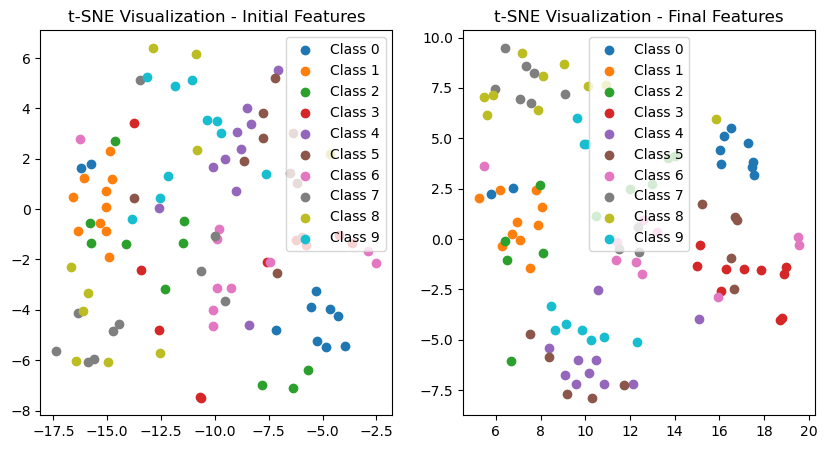

In [256]:
plot_tsne(flat_momentum_initial, flat_momentum_final)

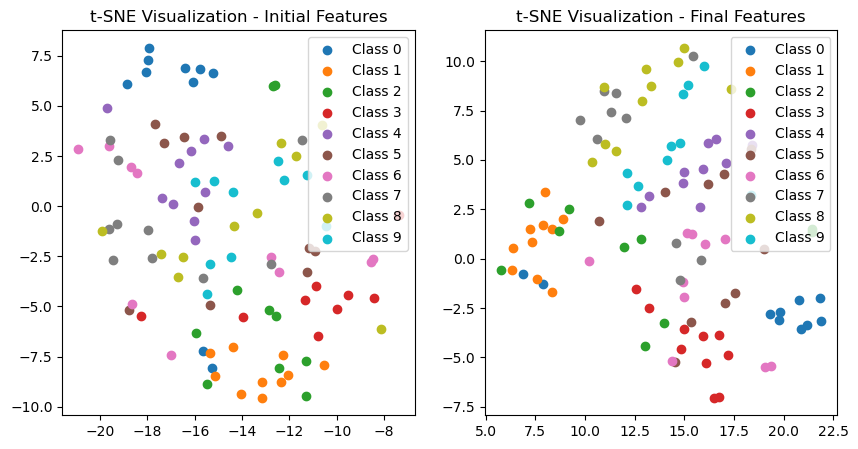

In [263]:
plot_tsne(flat_rms_initial, flat_rms_final)

WE OBSERVE SOME CLUSTERING IN ALL THE MODELS. THE DEGREE OF CLUSTERING SEEMS TO BE MORE IN SGD WITH MOMENTUM CASE
SINCE WE ARE ONLY USING 1000 IMAGES IN TOTAL, THE MODEL IS NOT ABLE TO DISCRIMINATE TO THAT EXTENT

In [267]:
class modified_CNN(nn.Module):

    def __init__(self,image_size =28, mlp_hidden_layer = 49,num_classes=10,dropout =None,BatchNorm = None, dropout_val = 0.2):

        super(modified_CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(nn.Conv2d(in_channels =1, out_channels = 4,kernel_size = 5,stride =1 , padding = 2),
                                    nn.ReLU(),
                                    )   
        
        self.pooling1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer2 = nn.Sequential(nn.Conv2d(in_channels =4, out_channels = 4, kernel_size = 5, stride=1, padding = 2),
                                    nn.ReLU(),
                                    )
        
        self.pooling2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.mlp = nn.Sequential(
            nn.Linear(4*(image_size//4)*(image_size//4), mlp_hidden_layer),
            nn.BatchNorm1d(mlp_hidden_layer) if BatchNorm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout_val) if dropout else nn.Identity(),
            nn.Linear(mlp_hidden_layer, num_classes),
            #nn.Softmax()
            )
        
        
    def forward(self, x):

        x = self.conv_layer1(x)
        activation1 = x
        x = self.pooling1(x)
        x = self.conv_layer2(x)
        activation2 = x
        x = self.pooling2(x)
        x = x.view(x.size(0), -1)
        flat = x
        x = self.mlp(x)

        return x,activation1,activation2,flat

NOTE: I have used SGD with momentum = 0.9 for all the following cases

### DROP OUT = 0.2 , lr = 0.001

Training Loss: 0.054146 	Training Accuracy: 0.987000 	Testing Loss: 0.205113 	Testing Accuracy: 0.940000


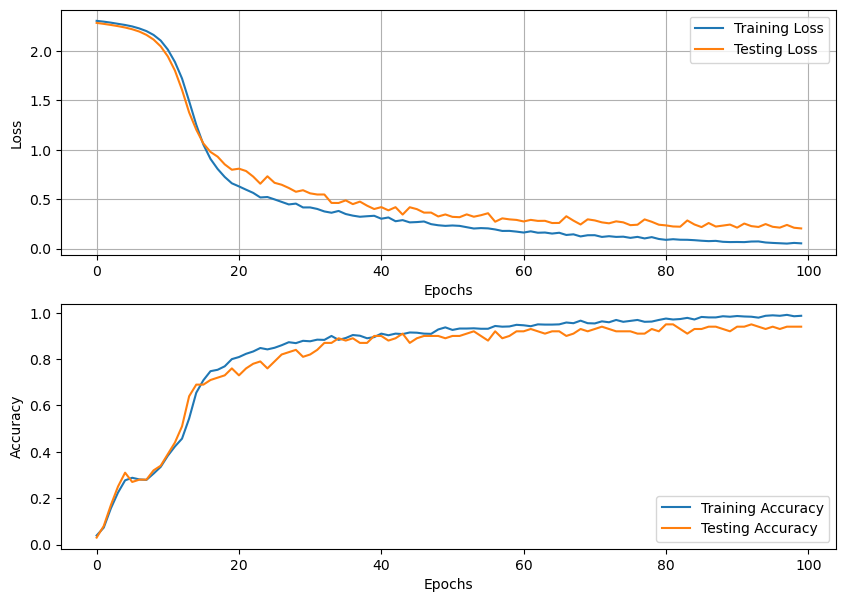

In [280]:
model = modified_CNN(dropout_val=0.2)
_ = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)

### DROP OUT = 0.2, LR = 0.01

Training Loss: 0.000260 	Training Accuracy: 1.000000 	Testing Loss: 0.133669 	Testing Accuracy: 0.970000


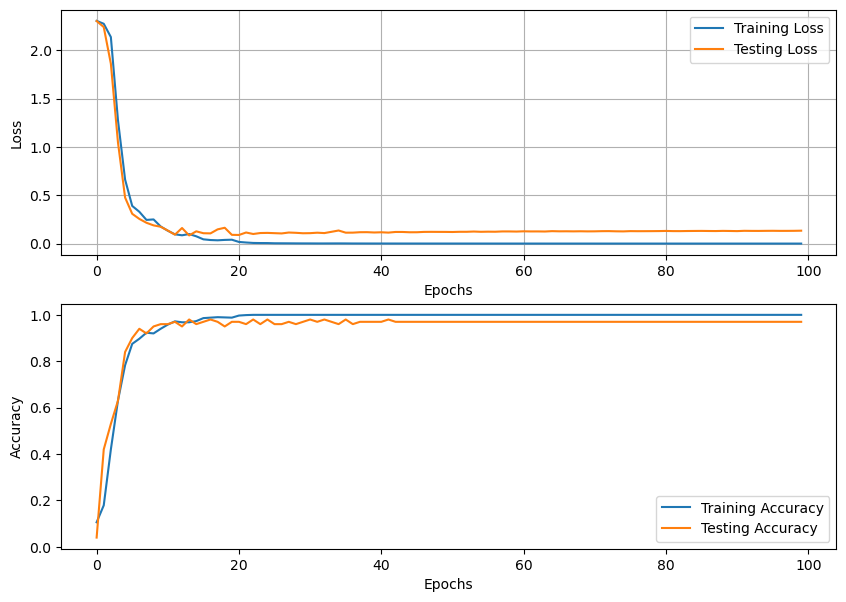

In [281]:
model = modified_CNN(dropout_val=0.2)
_ = set_params_train(model,epoch=100,lr = 0.01,optimizer="SGD",mometum=0.9)

### DROP OUT = 0.5, LR = 0.001

Training Loss: 0.000244 	Training Accuracy: 1.000000 	Testing Loss: 0.074386 	Testing Accuracy: 0.980000


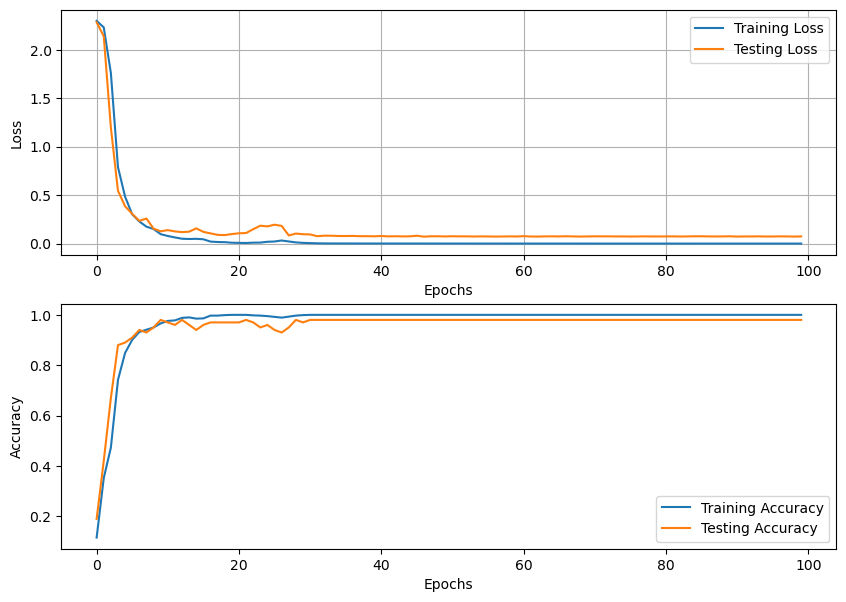

In [282]:
model = modified_CNN(dropout_val=0.5)
_ = set_params_train(model,epoch=100,lr = 0.01,optimizer="SGD",mometum=0.9)

### DROP OUT = 0.5, LR = 0.01

Training Loss: 0.000259 	Training Accuracy: 1.000000 	Testing Loss: 0.070745 	Testing Accuracy: 0.980000


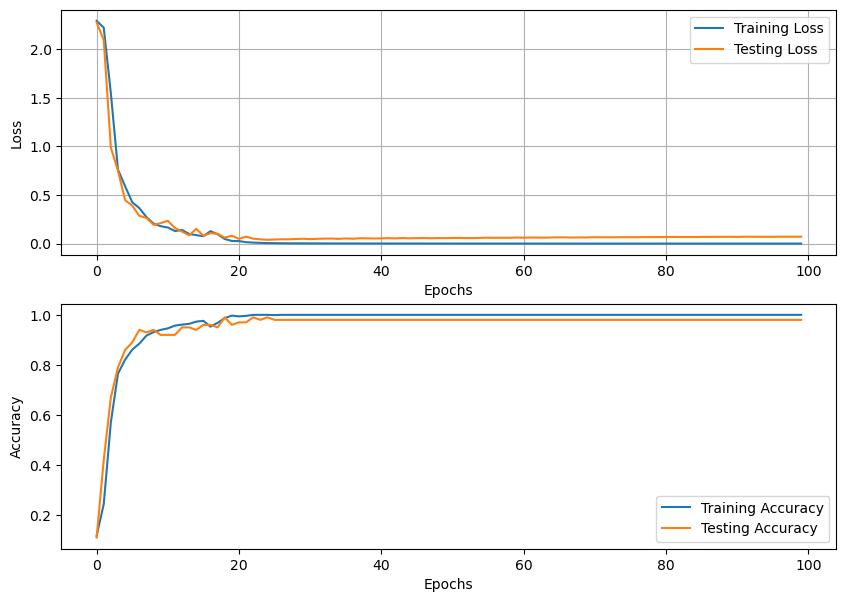

In [283]:
model = modified_CNN(dropout_val=0.5)
_ = set_params_train(model,epoch=100,lr = 0.01,optimizer="SGD",mometum=0.9)

### DROP OUT = 0.8, LR = 0.001

Training Loss: 0.080636 	Training Accuracy: 0.973000 	Testing Loss: 0.246012 	Testing Accuracy: 0.910000


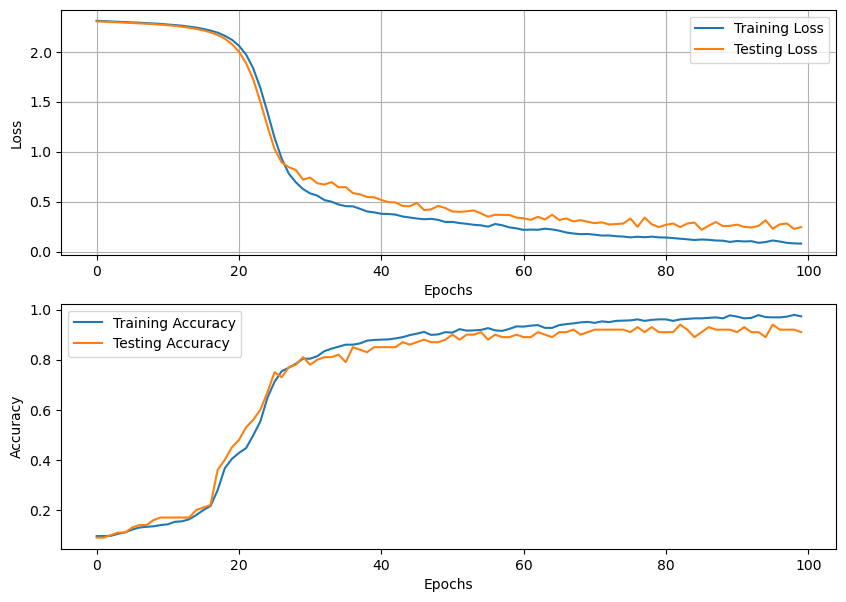

In [284]:
model = modified_CNN(dropout_val=0.8)
_ = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)

### DROP OUT = 0.8, LR = 0.01

Training Loss: 0.000760 	Training Accuracy: 1.000000 	Testing Loss: 0.128103 	Testing Accuracy: 0.980000


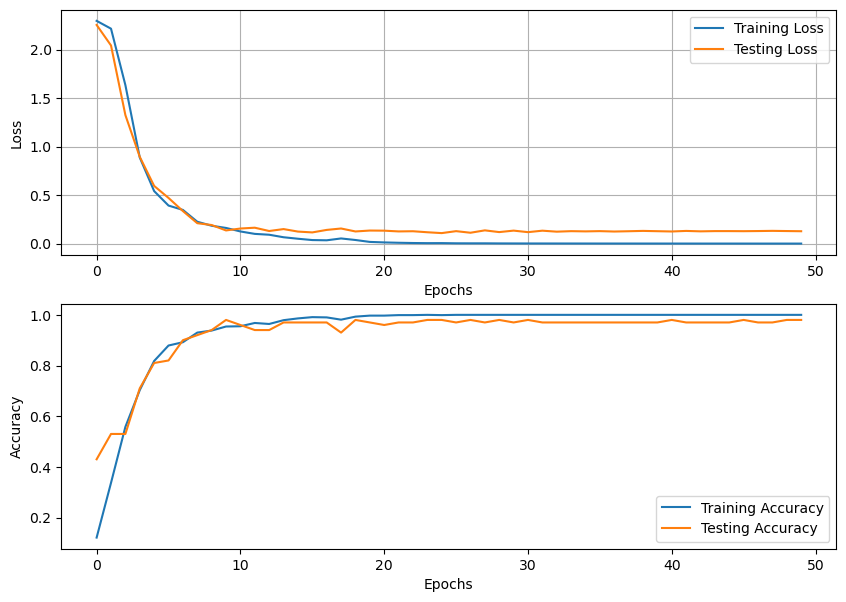

In [285]:
model = modified_CNN(dropout_val=0.8)
_ = set_params_train(model,epoch=50,lr = 0.01,optimizer="SGD",mometum=0.9)

There is consistent improvement while using Dropout 

### BATCH NORM

LR = 0.001

Training Loss: 0.071389 	Training Accuracy: 0.998000 	Testing Loss: 0.182179 	Testing Accuracy: 0.940000


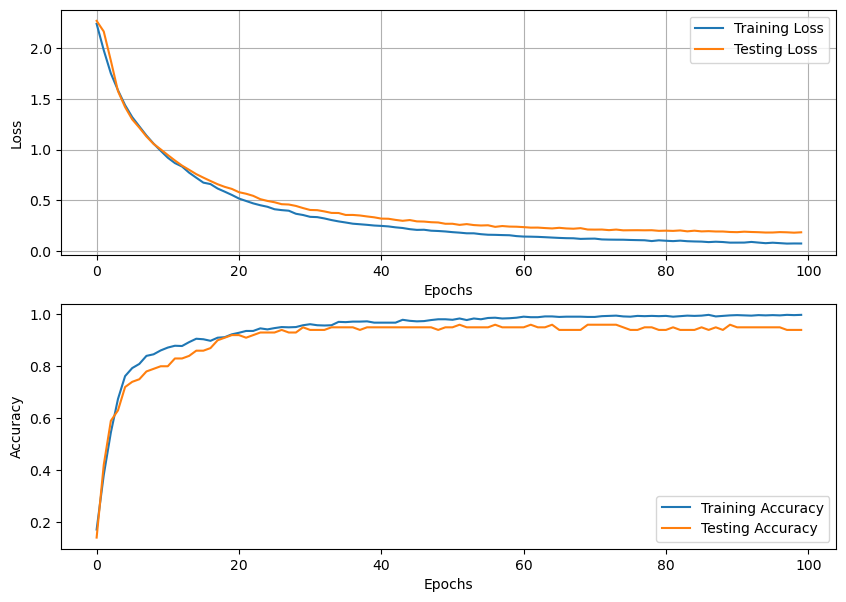

In [286]:
model = modified_CNN(BatchNorm=True)
_ = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)

### LR = 0.01

Training Loss: 0.003004 	Training Accuracy: 1.000000 	Testing Loss: 0.108824 	Testing Accuracy: 0.980000


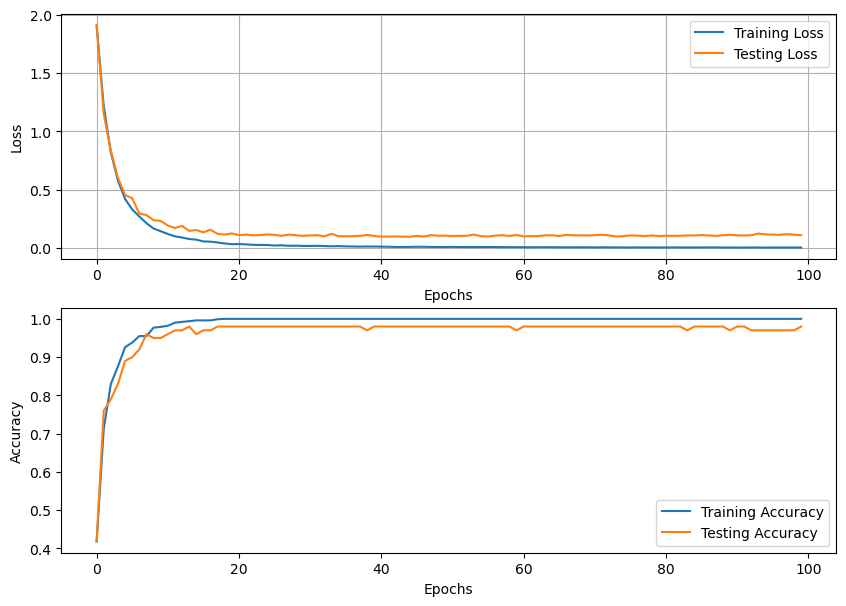

In [288]:
model = modified_CNN(BatchNorm=True)
_ = set_params_train(model,epoch=100,lr = 0.01,optimizer="SGD",mometum=0.9)

### There is marginal improvement in the accuracy of the model with the addition of batch normalization

### BATCHNORM AND DROPOUT 

LR = 0.001

Training Loss: 0.108503 	Training Accuracy: 0.984000 	Testing Loss: 0.120392 	Testing Accuracy: 0.980000


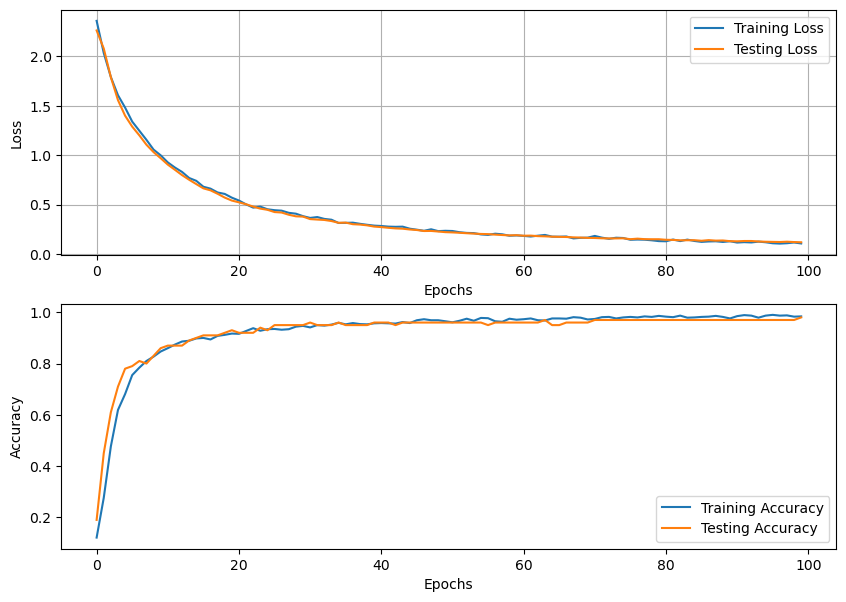

In [287]:
model = modified_CNN(dropout=True,dropout_val=0.2,BatchNorm=True)
_ = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)

### LR = 0.01 

Training Loss: 0.137127 	Training Accuracy: 0.984000 	Testing Loss: 0.212973 	Testing Accuracy: 0.960000


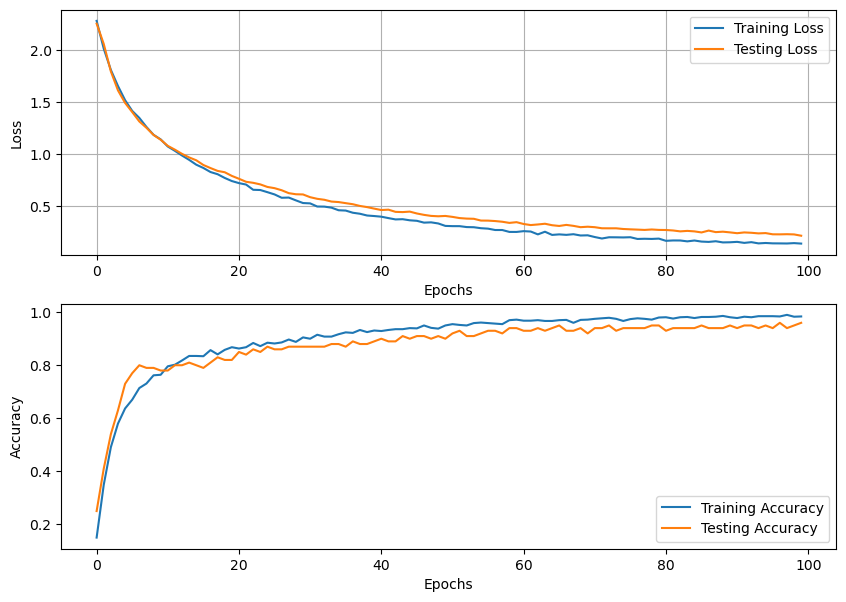

In [289]:
model = modified_CNN(dropout=True,dropout_val=0.2,BatchNorm=True)
_ = set_params_train(model,epoch=100,lr = 0.001,optimizer="SGD",mometum=0.9)

While using both BatchNorm and Dropout, there is improvement in lr = 0.001 case but not in lr = 0.01 case

### Model is already achieving close to perfect accuracy(98%) on the test set. The test set is small (100 images) and may not have very difficult images to classify. Even though the bottleneck features couldn't be discriminated using TSNE, the model seems to be performing well. In order to understand and test the effect, we might to have to test out on bigger train and test sets